In [1]:
import sys,os
sys.path.append('../')
# os.environ['LD_LIBRARY_PATH']='/home/aub3/Desktop/cuda/lib64/'

In [2]:
import argparse
import os
# import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [3]:
from dvalib.yolo.keras_yolo import preprocess_true_boxes, yolo_body,yolo_eval, yolo_head, yolo_loss
anchors_path = "model_data/yolo_anchors.txt"

In [4]:
data = np.load('/home/aub3/Desktop/underwater_data.npz')

In [5]:
YOLO_ANCHORS = np.array(((0.57273, 0.677385), (1.87446, 2.06253), (3.33843, 5.47434),(7.88282, 3.52778), (9.77052, 9.16828)))
class_names = ["red_buoy","green_buoy","yellow_buoy","path_marker","start_gate","channel"]
# anchors = np.array([float(x) for x in file(anchors_path).readline().split(',')]).reshape(-1, 2)
anchors = YOLO_ANCHORS

In [6]:
def get_detector_mask(boxes, anchors):
    '''
    Precompute detectors_mask and matching_true_boxes for training.
    Detectors mask is 1 for each spatial position in the final conv layer and
    anchor that should be active for the given boxes and 0 otherwise.
    Matching true boxes gives the regression targets for the ground truth box
    that caused a detector to be active or 0 otherwise.
    '''
    detectors_mask = [0 for i in range(len(boxes))]
    matching_true_boxes = [0 for i in range(len(boxes))]
    for i, box in enumerate(boxes):
        detectors_mask[i], matching_true_boxes[i] = preprocess_true_boxes(box, anchors, [416, 416])

    return np.array(detectors_mask), np.array(matching_true_boxes)

In [7]:
def process_data(images, boxes):
    images = [PIL.Image.fromarray(i) for i in images]
    orig_size = np.array([float(images[0].width), float(images[0].height)])
    orig_size = np.expand_dims(orig_size, axis=0)
    print orig_size
    processed_images = [i.resize((416, 416), PIL.Image.BICUBIC) for i in images]
    processed_images = [np.array(image, dtype=np.float) for image in processed_images]
    processed_images = [image/255. for image in processed_images]
    boxes = [box.reshape((-1, 5)) for box in boxes]
    boxes_extents = [box[:, [2, 1, 4, 3, 0]] for box in boxes]
    boxes_xy = [0.5 * (box[:, 3:5] + box[:, 1:3]) for box in boxes]
    boxes_wh = [box[:, 3:5] - box[:, 1:3] for box in boxes]
    print boxes_wh[0]
    boxes_xy = [boxxy / orig_size for boxxy in boxes_xy]
    boxes_wh = [boxwh / orig_size for boxwh in boxes_wh]
    print "width,height",boxes_wh[0]
    boxes = [np.concatenate((boxes_xy[i], boxes_wh[i], box[:, 0:1]), axis=1) for i, box in enumerate(boxes)]
    max_boxes = 0
    for boxz in boxes:
        if boxz.shape[0] > max_boxes:
            max_boxes = boxz.shape[0]
    print "max_boxes",max_boxes
    for i, boxz in enumerate(boxes):
        if boxz.shape[0]  < max_boxes:
            zero_padding = np.zeros( (max_boxes-boxz.shape[0], 5), dtype=np.float32)
            boxes[i] = np.vstack((boxz, zero_padding))
    return np.array(processed_images), np.array(boxes)

In [8]:
print len(data['images'])
print data['boxes'][10]
image_data, boxes = process_data(data['images'][:1000], data['boxes'][:1000])
print len(image_data),len(boxes)
print boxes[10].shape
print boxes[10]

629
[[  4   6  38 629 372]]
[[ 640.  480.]]
[[602 310]]
width,height [[ 0.940625    0.64583333]]
max_boxes 6
629 629
(6, 5)
[[ 0.49609375  0.42708333  0.9734375   0.69583333  4.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]


In [9]:
detectors_mask, matching_true_boxes = get_detector_mask(boxes, anchors)

In [10]:
detectors_mask[10].max()

1.0

In [11]:
print detectors_mask.shape
print matching_true_boxes.shape

(629, 13, 13, 5, 1)
(629, 13, 13, 5, 5)


In [16]:
def create_model(anchors, class_names, load_pretrained=True, freeze_body=True):
    '''
    returns the body of the model and the model
    load_pretrained: whether or not to load the pretrained model or initialize all weights
    freeze_body: whether or not to freeze all weights except for the last layer's
    model_body: YOLOv2 with new output layer
    model: YOLOv2 with custom loss Lambda layer
    '''
    detectors_mask_shape = (13, 13, 5, 1)
    matching_boxes_shape = (13, 13, 5, 5)

    # Create model input layers.
    image_input = Input(shape=(416, 416, 3))
    boxes_input = Input(shape=(None, 5))
    detectors_mask_input = Input(shape=detectors_mask_shape)
    matching_boxes_input = Input(shape=matching_boxes_shape)

    # Create model body.
    yolo_model = yolo_body(image_input, len(anchors), len(class_names))
    topless_yolo = Model(yolo_model.input, yolo_model.layers[-2].output)

    if load_pretrained:
        # Save topless yolo:
        topless_yolo_path = os.path.join('/home/aub3/repos/DeepVideoAnalytics/dvalib/yolo/model_data/', 'yolo_topless.h5')
        if not os.path.exists(topless_yolo_path):
            print("CREATING TOPLESS WEIGHTS FILE")
            yolo_path = '/home/aub3/repos/DeepVideoAnalytics/dvalib/yolo/model_data/yolo.h5'
            model_body = load_model(yolo_path)
            model_body = Model(model_body.inputs, model_body.layers[-2].output)
            model_body.save_weights(topless_yolo_path)
        topless_yolo.load_weights(topless_yolo_path)

    if freeze_body:
        for layer in topless_yolo.layers:
            layer.trainable = False
    else:
        for layer in topless_yolo.layers[:8]:
            print layer
            layer.trainable = False

    final_layer = Conv2D(len(anchors)*(5+len(class_names)), (1, 1), activation='linear')(topless_yolo.output)

    model_body = Model(image_input, final_layer)

    # Place model loss on CPU to reduce GPU memory usage.
    with tf.device('/cpu:0'):
        # TODO: Replace Lambda with custom Keras layer for loss.
        model_loss = Lambda(
            yolo_loss,
            output_shape=(1, ),
            name='yolo_loss',
            arguments={'anchors': anchors,
                       'num_classes': len(class_names)})([
                           model_body.output, boxes_input,
                           detectors_mask_input, matching_boxes_input
                       ])

    model = Model(
        [model_body.input, boxes_input, detectors_mask_input,
         matching_boxes_input], model_loss)

    return model_body, model

In [17]:
model_body, model = create_model(anchors, class_names)

In [20]:
def train(model, class_names, anchors, image_data, boxes, detectors_mask, matching_true_boxes, validation_split=0.1):
    '''
    retrain/fine-tune the model

    logs training with tensorboard

    saves training weights in current directory

    best weights according to val_loss is saved as trained_stage_3_best.h5
    '''
    model.compile(
        optimizer='adam', loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.


    logging = TensorBoard()
    checkpoint = ModelCheckpoint("trained_stage_3_best.h5", monitor='val_loss',
                                 save_weights_only=True, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

    model.fit([image_data, boxes, detectors_mask, matching_true_boxes],
              np.zeros(len(image_data)),
              validation_split=validation_split,
              batch_size=32,
              epochs=20,
              callbacks=[logging])
    model.save_weights('trained_stage_1.h5')

    model_body, model = create_model(anchors, class_names, load_pretrained=False, freeze_body=False)

    model.load_weights('trained_stage_1.h5')

    model.compile(
        optimizer='adam', loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.


    model.fit([image_data, boxes, detectors_mask, matching_true_boxes],
              np.zeros(len(image_data)),
              validation_split=0.1,
              batch_size=8,
              epochs=10,
              callbacks=[logging, checkpoint, early_stopping])

    model.save_weights('trained_stage_3.h5')

In [21]:
train(model,class_names,anchors,image_data,boxes,detectors_mask,matching_true_boxes)

Train on 566 samples, validate on 63 samples
Epoch 1/10
566/566 [==============================] - 56s - loss: 56.3392 - val_loss: 188043087.9048
Epoch 2/10
566/566 [==============================] - 50s - loss: 30.7765 - val_loss: 1542636.3559
Epoch 3/10
566/566 [==============================] - 52s - loss: 29.2438 - val_loss: 548.4039
Epoch 4/10
566/566 [==============================] - 51s - loss: 43.2207 - val_loss: 42705346.2540
Epoch 5/10
566/566 [==============================] - 51s - loss: 34.5652 - val_loss: 1371.3285
Epoch 6/10
566/566 [==============================] - 52s - loss: 25.5189 - val_loss: 54.1675
Epoch 7/10
566/566 [==============================] - 51s - loss: 20.5044 - val_loss: 23.9187
Epoch 8/10
566/566 [==============================] - 52s - loss: 21.2670 - val_loss: 25.5804
Epoch 9/10
566/566 [==============================] - 52s - loss: 17.9183 - val_loss: 22.2649
Epoch 10/10
566/566 [==============================] - 52s - loss: 16.4103 - val_loss: 2

In [22]:
import dvalib.yolo.draw_boxes as draw_boxes

In [23]:
reload(draw_boxes)

<module 'dvalib.yolo.draw_boxes' from '../dvalib/yolo/draw_boxes.pyc'>

In [24]:
import matplotlib.pyplot as plt

In [25]:
def draw(model_body, class_names, anchors, image_data, image_set='val',
            weights_name='trained_stage_3_best.h5', out_path="output_images", save_all=True):
    '''
    Draw bounding boxes on image data
    '''
    if image_set == 'train':
        image_data = np.array([np.expand_dims(image, axis=0)
            for image in image_data[:int(len(image_data)*.9)]])
    elif image_set == 'val':
        image_data = np.array([np.expand_dims(image, axis=0)
            for image in image_data[int(len(image_data)*.9):]])
    elif image_set == 'all':
        image_data = np.array([np.expand_dims(image, axis=0)
            for image in image_data])
    else:
        ValueError("draw argument image_set must be 'train', 'val', or 'all'")
    # model.load_weights(weights_name)
    print(image_data.shape)
    model_body.load_weights(weights_name)

    # Create output variables for prediction.
    yolo_outputs = yolo_head(model_body.output, anchors, len(class_names))
    input_image_shape = K.placeholder(shape=(2, ))
    boxes, scores, classes = yolo_eval(
        yolo_outputs, input_image_shape, score_threshold=0.5, iou_threshold=0)

    # Run prediction on overfit image.
    sess = K.get_session()  # TODO: Remove dependence on Tensorflow session.

    if  not os.path.exists(out_path):
        os.makedirs(out_path)
    for i in range(len(image_data)):
        out_boxes, out_scores, out_classes = sess.run(
            [boxes, scores, classes],
            feed_dict={
                model_body.input: image_data[i],
                input_image_shape: [image_data.shape[2], image_data.shape[3]],
                K.learning_phase(): 0
            })
        print('Found {} boxes for image.'.format(len(out_boxes)))
        print(out_boxes)

        # Plot image with predicted boxes.
        image_with_boxes = draw_boxes.draw_boxes(image_data[i][0], out_boxes, out_classes,
                                    class_names, out_scores)
        # Save the image:
        if save_all or (len(out_boxes) > 0):
            image = PIL.Image.fromarray(image_with_boxes)
            image.save(os.path.join(out_path,str(i)+'.png'))
        plt.imshow(image_with_boxes, interpolation='nearest')
        plt.show()

(63, 1, 416, 416, 3)
Found 3 boxes for image.
[[ 160.02108765    4.59013033  231.51516724   90.24308777]
 [ 281.3637085    14.69940567  349.74972534   67.63182068]
 [ 217.5962677   224.79519653  273.39498901  265.75177002]]
('channel 0.98', (5, 160), (90, 232))
('red_buoy 0.96', (15, 281), (68, 350))
('green_buoy 0.96', (225, 218), (266, 273))


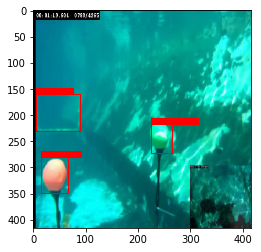

Found 1 boxes for image.
[[ 136.55534363    4.88747501  220.10388184   89.16378784]]
('channel 0.93', (5, 137), (89, 220))


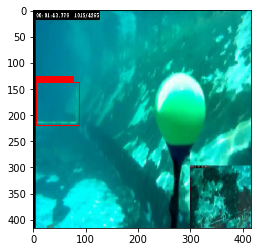

Found 2 boxes for image.
[[ 301.65496826   66.23622131  369.09558105  152.84439087]
 [ -12.49614239   88.1496048   223.88972473  244.51358032]]
('path_marker 0.96', (66, 302), (153, 369))
('channel 0.75', (88, 0), (245, 224))


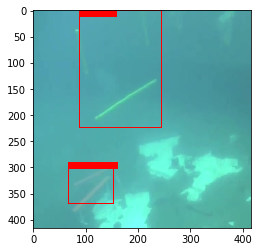

Found 2 boxes for image.
[[ 158.20986938    4.22719812  231.4355011    75.99990845]
 [ 173.01077271  212.09919739  251.37239075  270.24307251]]
('channel 0.96', (4, 158), (76, 231))
('green_buoy 0.95', (212, 173), (270, 251))


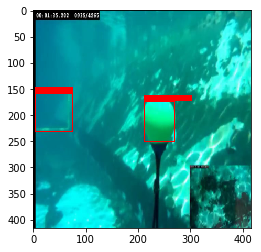

Found 1 boxes for image.
[[ 179.78741455   60.15836334  209.74194336   83.27085114]]
('green_buoy 0.97', (60, 180), (83, 210))


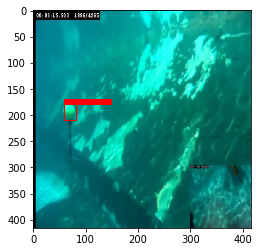

Found 3 boxes for image.
[[ 210.10473633  134.45043945  242.84402466  162.86611938]
 [ 322.93023682  126.80784607  388.38226318  142.78474426]
 [ 167.22770691  266.44546509  204.6181488   289.31948853]]
('red_buoy 0.99', (134, 210), (163, 243))
('path_marker 0.98', (127, 323), (143, 388))
('green_buoy 0.90', (266, 167), (289, 205))


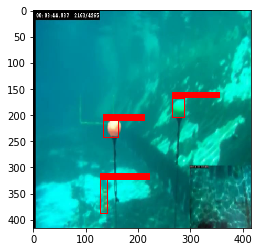

Found 1 boxes for image.
[[ 157.83906555  131.11846924  233.87335205  215.90338135]]
('channel 0.96', (131, 158), (216, 234))


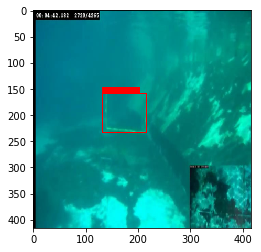

Found 3 boxes for image.
[[ 214.89414978  206.46025085  238.7769165   221.70608521]
 [ 191.38980103  304.87469482  208.00956726  318.67694092]
 [ 208.06144714  263.39538574  223.42965698  276.09692383]]
('yellow_buoy 1.00', (206, 215), (222, 239))
('green_buoy 0.99', (305, 191), (319, 208))
('red_buoy 0.95', (263, 208), (276, 223))


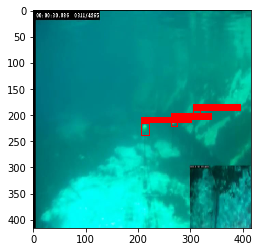

Found 3 boxes for image.
[[ 183.55308533  239.6824646   204.31559753  252.58561707]
 [ 175.18617249  305.60772705  192.48834229  318.31854248]
 [ 177.63711548  271.4118042   193.99749756  285.61260986]]
('yellow_buoy 0.97', (240, 184), (253, 204))
('green_buoy 0.94', (306, 175), (318, 192))
('red_buoy 0.59', (271, 178), (286, 194))


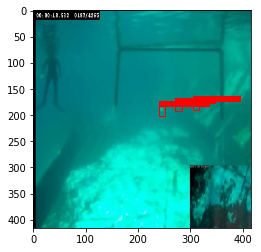

Found 0 boxes for image.
[]


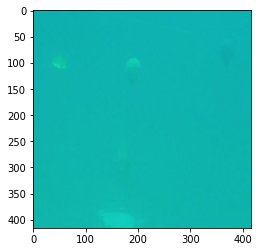

Found 0 boxes for image.
[]


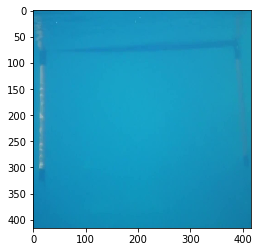

Found 1 boxes for image.
[[ 102.76152802  180.70376587  256.70336914  315.22711182]]
('channel 0.80', (181, 103), (315, 257))


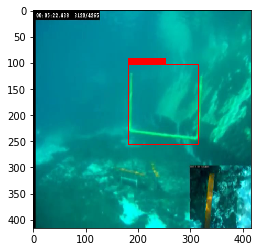

Found 0 boxes for image.
[]


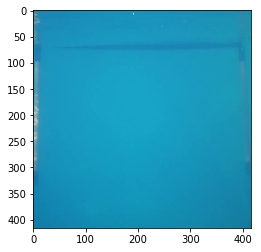

Found 2 boxes for image.
[[ 292.68771362  185.07012939  377.38369751  211.95608521]
 [ 358.57266235   63.96623611  386.72784424  182.41455078]]
('path_marker 0.99', (185, 293), (212, 377))
('path_marker 0.87', (64, 359), (182, 387))


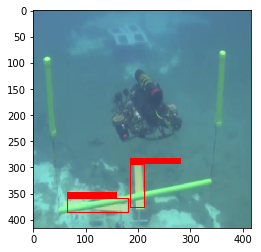

Found 4 boxes for image.
[[ 270.14651489    7.58452225  327.3482666    66.46073914]
 [ 153.85513306   16.15622711  221.16786194  100.44989777]
 [ 191.45375061  228.60392761  249.56864929  266.93884277]
 [ 374.71884155   61.68848801  410.43014526   82.71102142]]
('red_buoy 0.98', (8, 270), (66, 327))
('channel 0.97', (16, 154), (100, 221))
('green_buoy 0.95', (229, 191), (267, 250))
('path_marker 0.71', (62, 375), (83, 410))


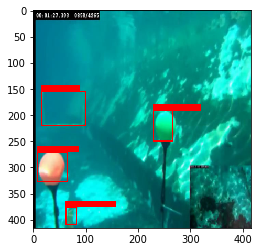

Found 0 boxes for image.
[]


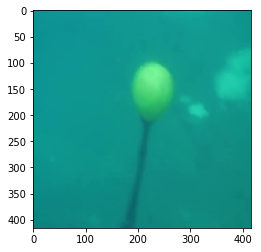

Found 0 boxes for image.
[]


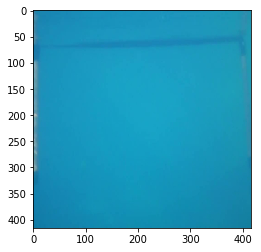

Found 0 boxes for image.
[]


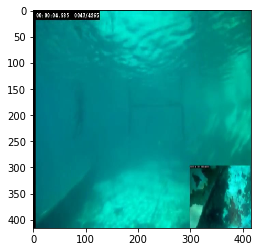

Found 4 boxes for image.
[[ 364.43951416  106.71614075  411.52667236  128.86955261]
 [ 190.75100708  323.93453979  241.24021912  362.5894165 ]
 [ 160.31932068   28.52521706  225.67871094  108.86781311]
 [ 262.26391602  156.43258667  323.50335693  214.42669678]]
('path_marker 0.97', (107, 364), (129, 412))
('green_buoy 0.91', (324, 191), (363, 241))
('channel 0.91', (29, 160), (109, 226))
('red_buoy 0.83', (156, 262), (214, 324))


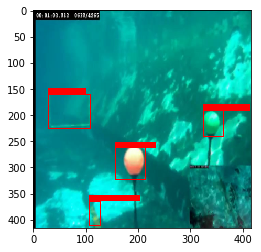

Found 5 boxes for image.
[[ 221.21383667   73.56796265  257.47189331   99.17576599]
 [ 206.09376526  188.81785583  235.82723999  209.0821991 ]
 [ 182.51713562  295.9468689   213.06507874  318.39163208]
 [ 301.49291992  397.02658081  353.05776978  411.69735718]
 [ 304.94116211  190.38146973  348.10766602  206.05906677]]
('yellow_buoy 1.00', (74, 221), (99, 257))
('red_buoy 0.99', (189, 206), (209, 236))
('green_buoy 0.97', (296, 183), (318, 213))
('path_marker 0.96', (397, 301), (412, 353))
('path_marker 0.96', (190, 305), (206, 348))


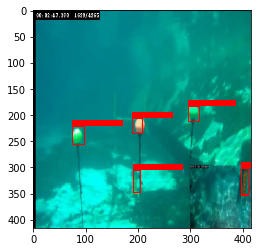

Found 0 boxes for image.
[]


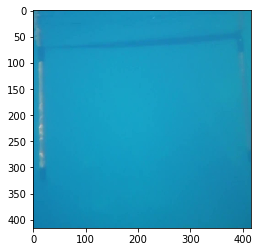

Found 6 boxes for image.
[[ 224.18359375   99.4651947   255.37557983  123.7169342 ]
 [ 150.04888916  174.98812866  210.01141357  241.33660889]
 [ 303.22265625  210.49295044  355.36486816  225.15771484]
 [ 183.82432556  320.53619385  213.34468079  342.99356079]
 [ 304.68768311  395.62164307  358.427948    410.73065186]
 [ 211.75860596  222.96151733  240.53778076  243.50874329]]
('yellow_buoy 1.00', (99, 224), (124, 255))
('channel 0.99', (175, 150), (241, 210))
('path_marker 0.98', (210, 303), (225, 355))
('green_buoy 0.97', (321, 184), (343, 213))
('path_marker 0.94', (396, 305), (411, 358))
('red_buoy 0.83', (223, 212), (244, 241))


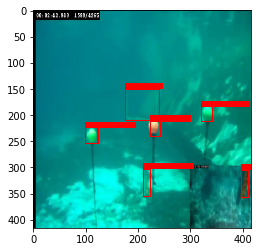

Found 5 boxes for image.
[[ 290.01965332    3.42142248  325.05651855   12.2548027 ]
 [ 230.66105652  254.61755371  263.03619385  276.36865234]
 [ 346.44812012  128.95033264  395.62710571  144.2631073 ]
 [ 162.57203674   97.72631073  231.05314636  163.77719116]
 [ 254.7665863   136.85360718  295.78811646  164.05104065]]
('yellow_buoy 0.99', (3, 290), (12, 325))
('green_buoy 0.99', (255, 231), (276, 263))
('path_marker 0.97', (129, 346), (144, 396))
('channel 0.94', (98, 163), (164, 231))
('red_buoy 0.84', (137, 255), (164, 296))


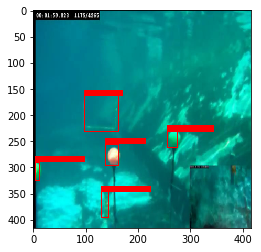

Found 0 boxes for image.
[]


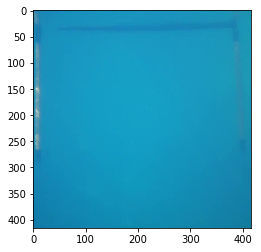

Found 4 boxes for image.
[[ 261.74267578  125.39866638  296.54919434  151.10762024]
 [ 175.06997681   77.74018097  243.02474976  154.37950134]
 [ 227.96606445  253.90634155  261.89511108  275.00888062]
 [ 372.44970703  122.02815247  406.94775391  142.3782196 ]]
('red_buoy 0.98', (125, 262), (151, 297))
('channel 0.98', (78, 175), (154, 243))
('green_buoy 0.98', (254, 228), (275, 262))
('path_marker 0.95', (122, 372), (142, 407))


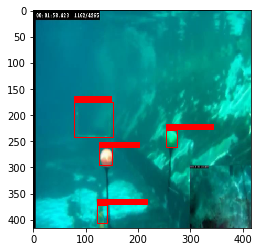

Found 5 boxes for image.
[[ 221.16679382  141.62924194  254.56767273  165.24914551]
 [ 211.60670471  265.09414673  243.84803772  287.32568359]
 [ 307.29055786  245.37130737  358.69937134  260.7124939 ]
 [ 300.90026855  390.31439209  364.81369019  415.70681763]
 [ 189.05770874  366.64883423  218.33790588  390.65536499]]
('yellow_buoy 1.00', (142, 221), (165, 255))
('red_buoy 1.00', (265, 212), (287, 244))
('path_marker 0.98', (245, 307), (261, 359))
('path_marker 0.91', (390, 301), (416, 365))
('green_buoy 0.55', (367, 189), (391, 218))


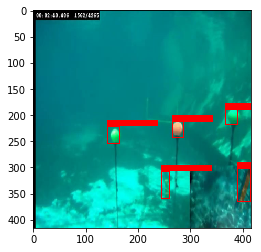

Found 1 boxes for image.
[[ 150.60028076  193.73606873  260.9833374   246.09466553]]
('red_buoy 0.75', (194, 151), (246, 261))


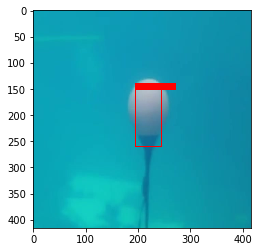

Found 2 boxes for image.
[[ 133.30081177  109.15233612  212.58270264  194.89642334]
 [ 377.77111816  159.06228638  412.27001953  178.12413025]]
('channel 0.99', (109, 133), (195, 213))
('path_marker 0.95', (159, 378), (178, 412))


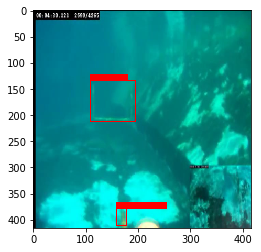

Found 1 boxes for image.
[[ 118.76070404  142.57899475  241.54229736  212.09605408]]
('yellow_buoy 0.79', (143, 119), (212, 242))


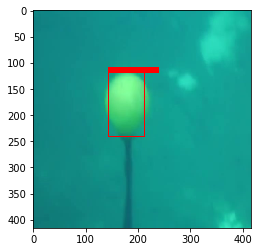

Found 3 boxes for image.
[[ 188.52281189  304.02697754  205.56733704  317.68811035]
 [ 201.83654785  262.86712646  217.88560486  274.81936646]
 [ 206.96621704  208.52062988  230.29916382  223.184021  ]]
('green_buoy 0.99', (304, 189), (318, 206))
('red_buoy 0.98', (263, 202), (275, 218))
('yellow_buoy 0.97', (209, 207), (223, 230))


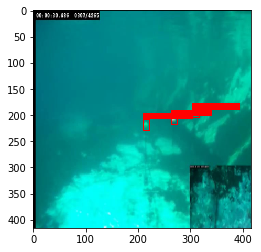

Found 4 boxes for image.
[[ 191.25587463  228.78173828  246.91778564  265.94186401]
 [ 155.71482849   13.202384    233.33460999  100.40096283]
 [ 266.31204224    7.18766689  321.74276733   68.56847382]
 [ 375.30203247   61.38284683  412.01916504   81.20775604]]
('green_buoy 0.98', (229, 191), (266, 247))
('channel 0.97', (13, 156), (100, 233))
('red_buoy 0.95', (7, 266), (69, 322))
('path_marker 0.80', (61, 375), (81, 412))


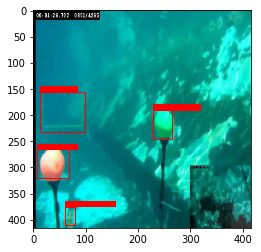

Found 1 boxes for image.
[[ 105.71666718  167.25015259  235.04862976  239.07019043]]
('yellow_buoy 0.80', (167, 106), (239, 235))


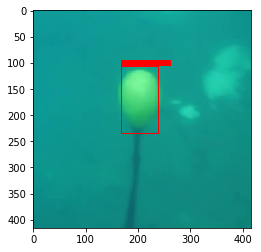

Found 3 boxes for image.
[[ 181.13165283  126.08386993  209.28504944  147.09216309]
 [ 294.11572266  385.94137573  322.90829468  400.50408936]
 [ 215.81237793   12.05843163  248.95166016   36.51344681]]
('green_buoy 0.98', (126, 181), (147, 209))
('path_marker 0.79', (386, 294), (401, 323))
('yellow_buoy 0.59', (12, 216), (37, 249))


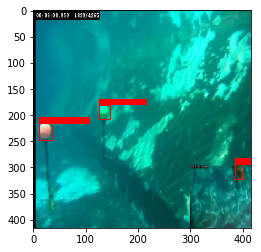

Found 2 boxes for image.
[[ 213.0957489   308.51257324  226.72164917  320.64208984]
 [ 221.23443604  262.69146729  233.81187439  272.41549683]]
('green_buoy 0.99', (309, 213), (321, 227))
('yellow_buoy 0.87', (263, 221), (272, 234))


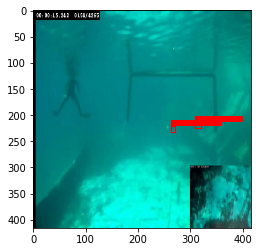

Found 2 boxes for image.
[[ 290.06063843  198.93769836  366.1859436   224.60246277]
 [ 347.82196045   72.43515778  377.7961731   197.70645142]]
('path_marker 0.94', (199, 290), (225, 366))
('path_marker 0.68', (72, 348), (198, 378))


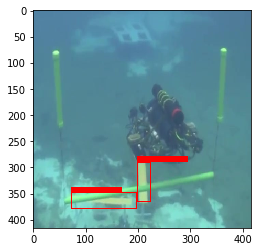

Found 4 boxes for image.
[[ 140.00427246  111.51402283  197.54096985  176.98149109]
 [ 213.5043335   126.98133087  239.01170349  142.01676941]
 [ 187.10786438  224.18481445  209.69403076  241.06684875]
 [ 155.81300354  285.59875488  183.0776825   304.10662842]]
('channel 0.99', (112, 140), (177, 198))
('yellow_buoy 0.98', (127, 214), (142, 239))
('red_buoy 0.97', (224, 187), (241, 210))
('green_buoy 0.94', (286, 156), (304, 183))


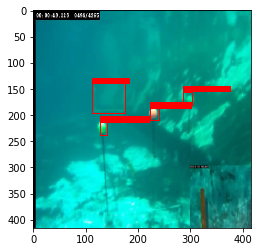

Found 0 boxes for image.
[]


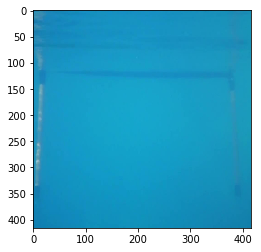

Found 4 boxes for image.
[[ 279.65402222   52.13833618  342.02871704   99.13136292]
 [ 159.93667603    3.87453127  231.26351929   86.82427979]
 [ 205.70376587  243.57766724  262.92276001  288.22741699]
 [ 381.75009155   61.05874252  414.14294434   81.07446289]]
('red_buoy 0.98', (52, 280), (99, 342))
('channel 0.97', (4, 160), (87, 231))
('green_buoy 0.96', (244, 206), (288, 263))
('path_marker 0.94', (61, 382), (81, 414))


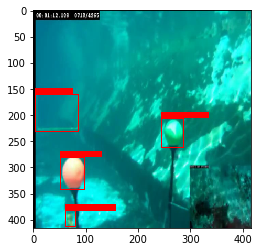

Found 5 boxes for image.
[[ 231.59115601   91.81047058  262.85931396  114.71131897]
 [ 213.19729614  201.3760376   246.02032471  224.9041748 ]
 [ 309.79492188  193.55657959  357.76663208  208.14701843]
 [ 194.66992188  301.0199585   225.35612488  320.63104248]
 [ 317.42523193  385.40582275  357.47424316  400.03955078]]
('yellow_buoy 1.00', (92, 232), (115, 263))
('red_buoy 1.00', (201, 213), (225, 246))
('path_marker 0.97', (194, 310), (208, 358))
('green_buoy 0.96', (301, 195), (321, 225))
('path_marker 0.95', (385, 317), (400, 357))


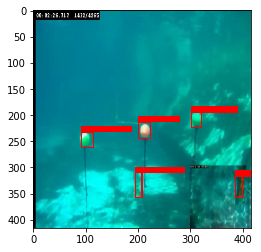

Found 3 boxes for image.
[[ 222.39482117  235.83506775  257.00735474  258.03152466]
 [ 217.0562439   357.55154419  245.86340332  379.37518311]
 [ 303.99676514  380.47579956  380.26574707  413.98989868]]
('yellow_buoy 1.00', (236, 222), (258, 257))
('red_buoy 0.99', (358, 217), (379, 246))
('path_marker 0.51', (380, 304), (414, 380))


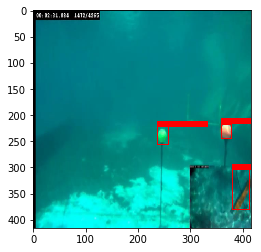

Found 3 boxes for image.
[[ 278.86993408  109.52210999  339.51965332  162.03321838]
 [ 159.13461304    6.30118942  235.97769165   90.92092896]
 [ 201.45263672  288.28338623  259.13418579  328.21447754]]
('red_buoy 0.99', (110, 279), (162, 340))
('channel 0.99', (6, 159), (91, 236))
('green_buoy 0.99', (288, 201), (328, 259))


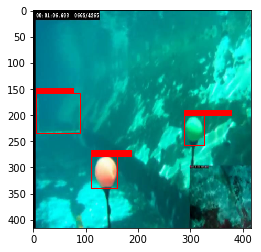

Found 3 boxes for image.
[[ 154.81170654   17.43906021  214.66293335   93.32331848]
 [ 179.08537292  157.26956177  208.6660614   178.46902466]
 [ 292.743927    384.44784546  325.38809204  399.58682251]]
('channel 0.98', (17, 155), (93, 215))
('green_buoy 0.97', (157, 179), (178, 209))
('path_marker 0.93', (384, 293), (400, 325))


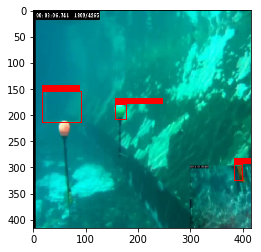

Found 3 boxes for image.
[[ 184.54164124  239.58668518  204.1394043   252.10823059]
 [ 176.25839233  303.79257202  192.56008911  316.43481445]
 [ 177.5319519   272.60061646  193.52862549  287.11605835]]
('yellow_buoy 0.95', (240, 185), (252, 204))
('green_buoy 0.91', (304, 176), (316, 193))
('red_buoy 0.63', (273, 178), (287, 194))


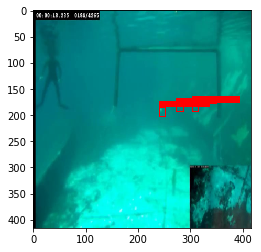

Found 1 boxes for image.
[[  85.24097443  192.51577759  202.17762756  337.34716797]]
('start_gate 0.72', (193, 85), (337, 202))


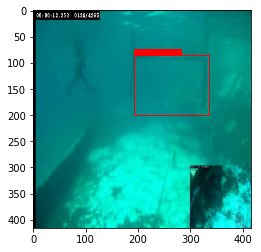

Found 4 boxes for image.
[[  93.00475311  107.23732758  125.54112244  128.14755249]
 [  58.7417984   284.48574829   83.40042114  304.21514893]
 [ 217.35656738  150.54501343  262.02099609  202.33547974]
 [ 102.6179657   199.8805542   133.39924622  219.24456787]]
('yellow_buoy 0.98', (107, 93), (128, 126))
('green_buoy 0.82', (284, 59), (304, 83))
('path_marker 0.69', (151, 217), (202, 262))
('red_buoy 0.66', (200, 103), (219, 133))


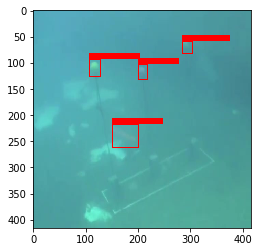

Found 3 boxes for image.
[[ 207.05883789  223.74751282  266.08300781  264.60623169]
 [ 159.1089325     4.84519863  231.45863342   91.14315796]
 [ 279.36010742   11.65796947  345.98382568   66.97033691]]
('green_buoy 0.99', (224, 207), (265, 266))
('channel 0.99', (5, 159), (91, 231))
('red_buoy 0.97', (12, 279), (67, 346))


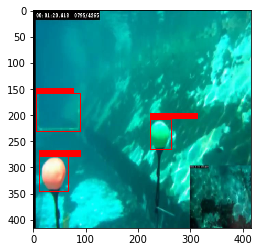

Found 0 boxes for image.
[]


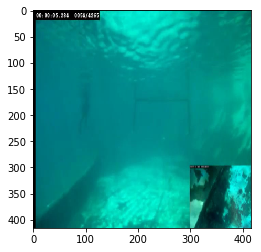

Found 4 boxes for image.
[[  93.00475311  107.23732758  125.54112244  128.14755249]
 [  58.7417984   284.48574829   83.40042114  304.21514893]
 [ 217.35656738  150.54501343  262.02099609  202.33547974]
 [ 102.6179657   199.8805542   133.39924622  219.24456787]]
('yellow_buoy 0.98', (107, 93), (128, 126))
('green_buoy 0.82', (284, 59), (304, 83))
('path_marker 0.69', (151, 217), (202, 262))
('red_buoy 0.66', (200, 103), (219, 133))


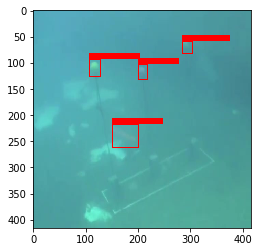

Found 1 boxes for image.
[[ 136.48025513  208.49984741  393.38537598  387.71542358]]
('channel 0.73', (208, 136), (388, 393))


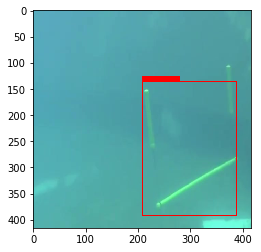

Found 6 boxes for image.
[[ 172.05177307  104.54032135  230.8150177   180.76113892]
 [ 338.47955322  147.4324646   391.80319214  163.48191833]
 [ 210.82554626  266.48080444  241.91656494  290.09359741]
 [ 243.17796326  156.24888611  275.05187988  180.3135376 ]
 [ 296.4994812   384.17147827  325.45376587  399.20907593]
 [ 274.82675171   14.4326582   310.80987549   41.64175034]]
('channel 1.00', (105, 172), (181, 231))
('path_marker 0.99', (147, 338), (163, 392))
('green_buoy 0.98', (266, 211), (290, 242))
('red_buoy 0.95', (156, 243), (180, 275))
('path_marker 0.75', (384, 296), (399, 325))
('yellow_buoy 0.57', (14, 275), (42, 311))


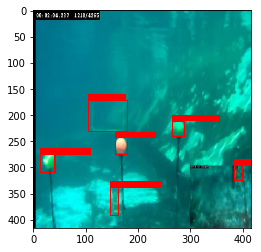

Found 0 boxes for image.
[]


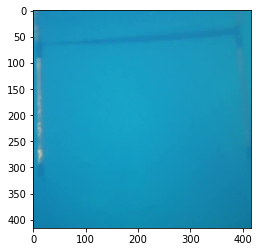

Found 3 boxes for image.
[[ 209.45944214  226.98243713  269.95727539  269.59255981]
 [ 157.20600891    7.17725277  233.14659119   89.71977997]
 [ 281.90545654   25.12586212  346.77301025   73.13192749]]
('green_buoy 0.99', (227, 209), (270, 270))
('channel 0.99', (7, 157), (90, 233))
('red_buoy 0.96', (25, 282), (73, 347))


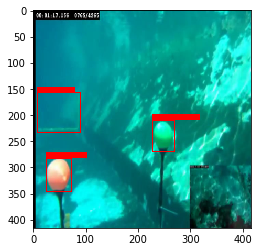

Found 0 boxes for image.
[]


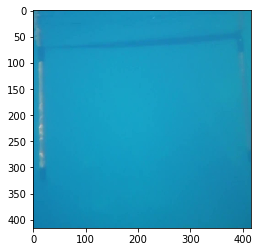

Found 0 boxes for image.
[]


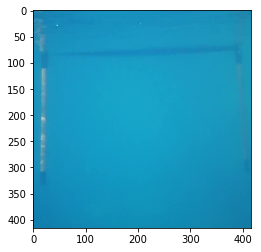

Found 3 boxes for image.
[[ 128.17660522   79.58641052  210.21524048  162.98757935]
 [ 197.2293396   163.70906067  264.41616821  229.24076843]
 [ 358.97854614  133.88275146  410.84979248  158.61703491]]
('channel 0.99', (80, 128), (163, 210))
('red_buoy 0.96', (164, 197), (229, 264))
('path_marker 0.95', (134, 359), (159, 411))


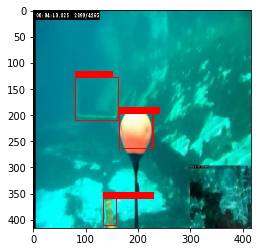

Found 0 boxes for image.
[]


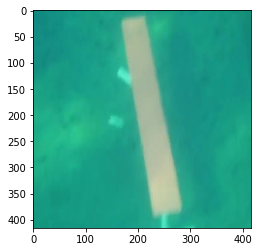

Found 4 boxes for image.
[[ 145.1729126    11.82077122  217.20838928   96.16866302]
 [ 199.52090454  231.93515015  272.75512695  291.69668579]
 [ 375.2956543    47.74205399  409.87020874   68.58177948]
 [ 301.89871216    9.93115616  362.10073853   25.8398056 ]]
('channel 0.98', (12, 145), (96, 217))
('green_buoy 0.97', (232, 200), (292, 273))
('path_marker 0.95', (48, 375), (69, 410))
('red_buoy 0.90', (10, 302), (26, 362))


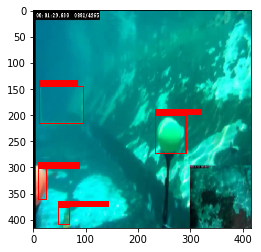

Found 1 boxes for image.
[[  69.05430603  154.57673645  220.46054077  249.21989441]]
('red_buoy 0.90', (155, 69), (249, 220))


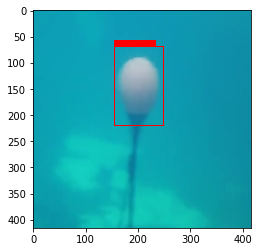

Found 0 boxes for image.
[]


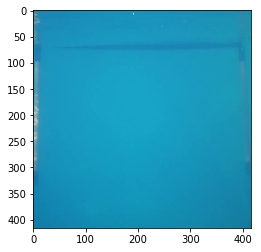

Found 5 boxes for image.
[[ 149.78108215   85.34101868  207.58189392  151.04966736]
 [ 180.53234863  223.52133179  209.30342102  243.90687561]
 [ 306.0112915   117.36068726  358.45001221  133.15606689]
 [ 296.20629883  394.76055908  336.7144165   408.82565308]
 [ 207.78193665  120.61491394  233.52012634  143.62573242]]
('channel 0.99', (85, 150), (151, 208))
('green_buoy 0.96', (224, 181), (244, 209))
('path_marker 0.94', (117, 306), (133, 358))
('path_marker 0.90', (395, 296), (409, 337))
('red_buoy 0.56', (121, 208), (144, 234))


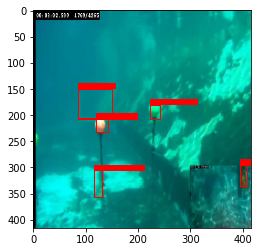

Found 2 boxes for image.
[[  55.83033752  206.83215332  293.68164062  348.67504883]
 [ 351.25094604  170.34725952  396.15359497  250.29495239]]
('channel 0.87', (207, 56), (349, 294))
('path_marker 0.83', (170, 351), (250, 396))


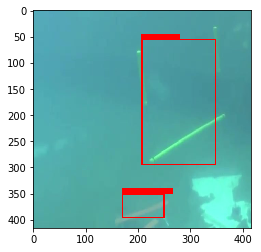

Found 0 boxes for image.
[]


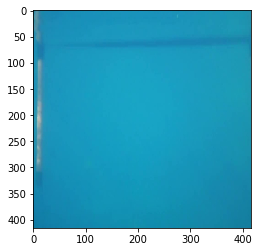

Found 4 boxes for image.
[[ 268.22717285  259.26507568  285.89138794  272.69683838]
 [ 281.68658447  192.23774719  302.75631714  208.27529907]
 [ 251.75848389  304.49163818  270.96987915  319.00927734]
 [ 180.82679749  169.58224487  248.48681641  231.12034607]]
('red_buoy 0.99', (259, 268), (273, 286))
('yellow_buoy 0.98', (192, 282), (208, 303))
('green_buoy 0.98', (304, 252), (319, 271))
('channel 0.78', (170, 181), (231, 248))


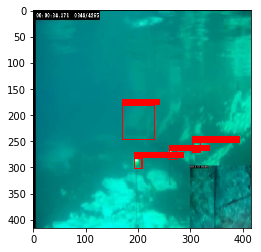

In [26]:
image_set='val' 
weights_name='trained_stage_3_best.h5'
save_all=False
draw(model_body,class_names,anchors,image_data,image_set=image_set,weights_name=weights_name,save_all=save_all)